From: https://github.com/GoogleCloudPlatform/practical-ml-vision-book

Presented here in accordance with Apache License, Version 2.0

In [1]:
# Import libraries and modules
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
np.set_printoptions(threshold=np.inf)

## Visualization utilities

In [2]:
def plot_latent_space(decoder, n=30, ranges=[-1, 1, -1, 1], figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(ranges[0], ranges[1], n)
    grid_y = np.linspace(ranges[2], ranges[3], n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

def plot_label_clusters(encoder, data, labels, vae=True):
    # display a 2D plot of the digit classes in the latent space
    if vae:
      z_mean, _, _ = encoder.predict(data)
    else:
      z_mean = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    for label in range(10): # mnist, 10 digits
        cx = np.mean(z_mean[labels == label, 0])
        cy = np.mean(z_mean[labels == label, 1])
        plt.text(cx, cy, str(label), color="white", fontsize=25, fontweight="bold")
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

## Autoencoder

Use Keras utilities to load MNIST data

In [3]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

The encoder goes from the inputs to the latent dim:

In [4]:
latent_dim = 2 # for easy visualization

encoder = tf.keras.Sequential([
    keras.Input(shape=(28, 28, 1), name="image_input"),
    layers.Conv2D(32, 3, activation="relu", strides=2, padding="same", name="e_conv1"),
    layers.Conv2D(64, 3, activation="relu", strides=2, padding="same", name="e_conv2"),
    layers.Flatten(name="e_flatten"),
    layers.Dense(latent_dim, name="e_dense")
], name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 e_conv1 (Conv2D)            (None, 14, 14, 32)        320       
                                                                 
 e_conv2 (Conv2D)            (None, 7, 7, 64)          18496     
                                                                 
 e_flatten (Flatten)         (None, 3136)              0         
                                                                 
 e_dense (Dense)             (None, 2)                 6274      
                                                                 
Total params: 25,090
Trainable params: 25,090
Non-trainable params: 0
_________________________________________________________________


The decoder goes from the latent dim back to the reconstructed image:

In [5]:
decoder = tf.keras.Sequential([
    keras.Input(shape=(latent_dim,), name="d_input"),
    layers.Dense(7 * 7 * 64, activation="relu", name="d_d1"),
    layers.Reshape((7, 7, 64), name="d_d2"),
    layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same", name="d_conv1"),
    layers.Conv2DTranspose(1, 3, activation="sigmoid", strides=2, padding="same", name="d_conv2")
], name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 d_d1 (Dense)                (None, 3136)              9408      
                                                                 
 d_d2 (Reshape)              (None, 7, 7, 64)          0         
                                                                 
 d_conv1 (Conv2DTranspose)   (None, 14, 14, 32)        18464     
                                                                 
 d_conv2 (Conv2DTranspose)   (None, 28, 28, 1)         289       
                                                                 
Total params: 28,161
Trainable params: 28,161
Non-trainable params: 0
_________________________________________________________________


The autoencoder consists of the encoder and the decoder blocks. We can write it as a Keras Functional model

In [6]:
encoder_inputs = keras.Input(shape=(28, 28, 1), name="image_input")
x = encoder(encoder_inputs)
decoder_output = decoder(x)
autoencoder = keras.Model(encoder_inputs, decoder_output, name="autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Sequential)        (None, 2)                 25090     
                                                                 
 decoder (Sequential)        (None, 28, 28, 1)         28161     
                                                                 
Total params: 53,251
Trainable params: 53,251
Non-trainable params: 0
_________________________________________________________________


In [7]:
autoencoder.compile(optimizer=keras.optimizers.Adam(), loss='mse')
history = autoencoder.fit(mnist_digits, mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 15s 25ms/step - loss: 0.0693
Epoch 2/30
547/547 [==============================] - 18s 33ms/step - loss: 0.0531
Epoch 3/30
547/547 [==============================] - 18s 33ms/step - loss: 0.0505
Epoch 4/30
547/547 [==============================] - 21s 38ms/step - loss: 0.0487
Epoch 5/30
547/547 [==============================] - 21s 38ms/step - loss: 0.0473
Epoch 6/30
547/547 [==============================] - 22s 40ms/step - loss: 0.0463
Epoch 7/30
547/547 [==============================] - 21s 38ms/step - loss: 0.0456
Epoch 8/30
547/547 [==============================] - 20s 37ms/step - loss: 0.0451
Epoch 9/30
547/547 [==============================] - 23s 41ms/step - loss: 0.0446
Epoch 10/30
547/547 [==============================] - 21s 38ms/step - loss: 0.0443
Epoch 11/30
547/547 [==============================] - 21s 38ms/step - loss: 0.0439
Epoch 12/30
547/547 [==============================] - 22s 40ms/step - loss: 0.0436
E

1875/1875 [==============================] - 3s 1ms/step


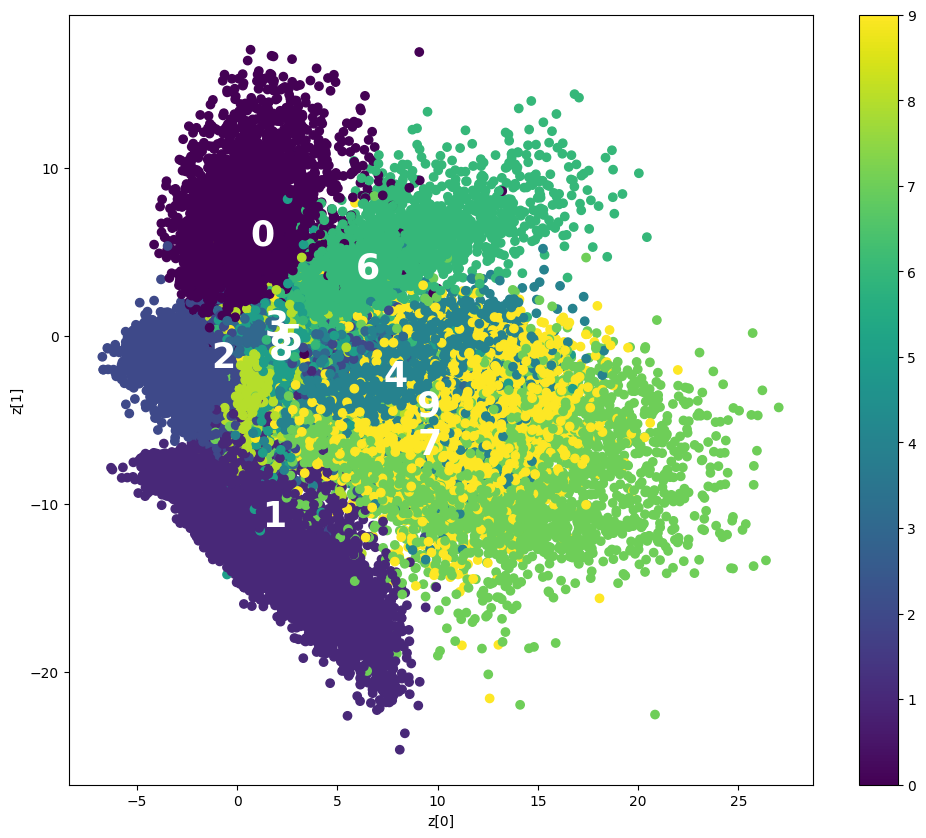

In [8]:
(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
plot_label_clusters(encoder, x_train, y_train, vae=False)

1/1 [==============================] - 0s 18ms/step


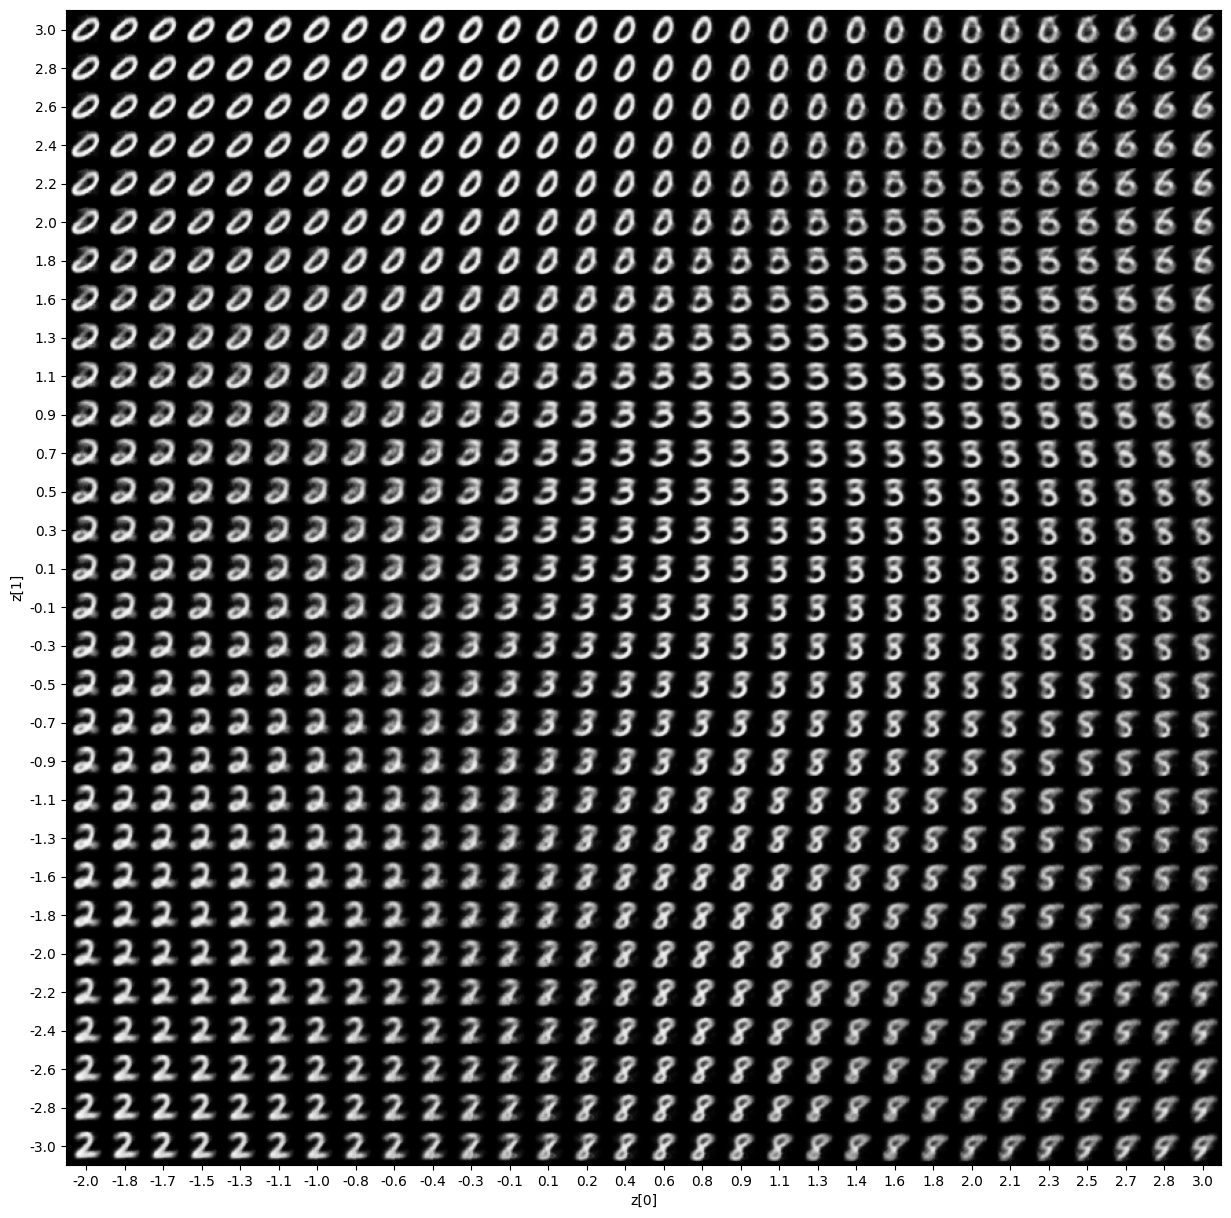

In [9]:
plot_latent_space(decoder, n=30, ranges=[-2, 3, -3, 3], figsize=15)